### Homework 8 PART TWO

RSA and MDS using MNIST

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist # changed to fashion_mnist
from tensorflow.keras.utils import to_categorical

# load MNIST data
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# image shape
sz = train_images.shape[1]

# need to reshape and preprocess the training/testing images
train_images_vec = train_images.reshape((train_images.shape[0], train_images.shape[1] * train_images.shape[2]))
train_images_vec = train_images_vec.astype('float32') / 255
test_images_vec = test_images.reshape((test_images.shape[0], test_images.shape[1] * test_images.shape[2]))
test_images_vec = test_images_vec.astype('float32') / 255

# also need to categorically encode the labels
train_labels_onehot = to_categorical(train_labels)
test_labels_onehot = to_categorical(test_labels)

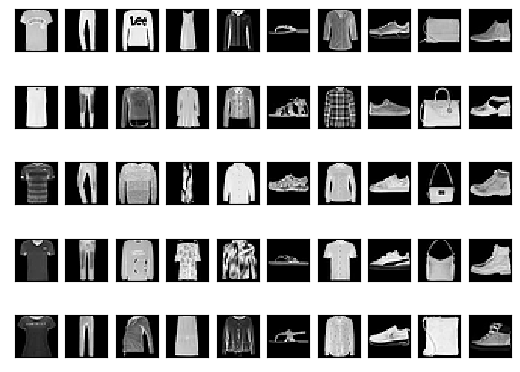

In [3]:
# Grab 5 exampes of each clothing type

Nexamples = 5
Ndigits = train_labels_onehot.shape[1]
nout = Ndigits

example_images = np.zeros((Ndigits*Nexamples, sz, sz))
for i in range(Ndigits):
    idx = np.where(test_labels==i)[0]
    example_images[i*Nexamples:(i+1)*Nexamples, :, :] = test_images[idx[0:Nexamples], :, :]

idx = 0
fig = plt.figure()
for i in range(Ndigits):
    for j in range(Nexamples):
        plt.subplot(Nexamples,Ndigits,j*Ndigits+i+1)
        plt.imshow(example_images[idx], cmap='gray', interpolation='none')
        plt.xticks([])
        plt.yticks([])
        idx = idx+1
plt.show()

example_images_vec = example_images.reshape((example_images.shape[0], example_images.shape[1] * example_images.shape[2]))
example_images_vec = example_images_vec.astype('float32') / 255

## Q2a
* Calculate and display RDM (representational dissimilariy matrices) based on raw pixel values of the sample
* Display 2d MSA constructued from the RDM

In [4]:
# calculate RDM for raw pixel images

from scipy import stats

RDM_Raw = np.zeros((Ndigits*Nexamples, Ndigits*Nexamples))
for i in range(Ndigits*Nexamples):
    for j in range(i, Ndigits*Nexamples):
        a = example_images[i,:,:]
        a = a.reshape((sz*sz))
        b = example_images[j,:,:]
        b = b.reshape((sz*sz))
        r, p = stats.kendalltau(a, b)
        RDM_Raw[i,j] = 1-r
        RDM_Raw[j,i] = 1-r

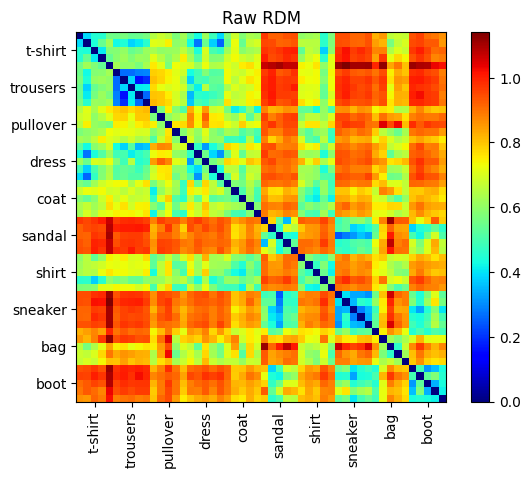

In [5]:
# axis tick locations
flabels = {0 : 't-shirt',
           1 : 'trousers',
           2 : 'pullover',
           3 : 'dress',
           4 : 'coat',
           5 : 'sandal',
           6 : 'shirt',
           7 : 'sneaker',
           8 : 'bag',
           9 : 'boot'}

def plt_rdm(RDM):
    xtks = np.arange(int(Nexamples/2), Ndigits*Nexamples, Nexamples)
    ytks = xtks
    xlabs = []
    ylabs = []
    for i in range(len(xtks)):
        xlabs.append(flabels[i])
        ylabs.append(flabels[i])

    # plot RDM
    fig = plt.figure()
    im = plt.imshow(RDM, cmap='jet', interpolation='none')
    plt.title('Raw RDM')
    plt.xticks(xtks, xlabs, rotation=90)
    plt.yticks(ytks, ylabs)
    plt.colorbar(im)
    plt.show()

plt_rdm(RDM_Raw)


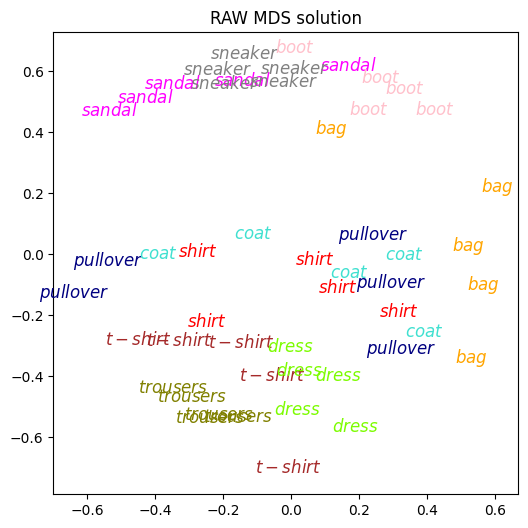

In [6]:
from sklearn.manifold import MDS

def mds_sol(RDM):
    # perform 2D MDS
    mdsmodel = MDS(n_components=2, metric=True, 
                dissimilarity='precomputed')
    mdssoln = mdsmodel.fit_transform(RDM)

    # labels and colors for digits
    dlabs = []
    clabs = []
    carr = ['brown', 'olive', 'navy', 'lawngreen', 'turquoise',
            'magenta', 'red', 'grey', 'orange', 'pink']
    for i in range(Ndigits):
        for j in range(Nexamples):
            dlabs.append(flabels[i])
            clabs.append(carr[i])

    plt.figure(figsize=(6,6))
    for i in range(Ndigits*Nexamples):
        plt.plot(mdssoln[i,0], mdssoln[i,1], 'w+')
        plt.text(mdssoln[i,0], mdssoln[i,1], 
                r'$ {} $'.format(dlabs[i]), size='large',
                color=clabs[i],
                horizontalalignment='center')
    plt.title('RAW MDS solution')
    plt.show()

mds_sol(RDM_Raw)

### Discussion

*Representational Dissimilarity Matrices (RDM)*
* For the squares across the diagonal, images have low `dissimilarity` scores $\rightarrow$ each piece of clothing is most similar to clothing of the same type
* Furthermore across cateogories, upper-body wear (`["t-shirt", "trousers", "pullovers", "dress", "coat", "shirt"]`) appear to be similar to eachother
  *  same with  (`['scandal', "bag", "sneaker"]`) 
  * The only group dissimilar to all other groups is `bag`

*Multi-dimensional Scaling (MDS)*

* Upperbody wear and lower body wear seam to cluster together
* Trousers are the most similar category (each on top of another)




## Q2(b)
Examine similarity structure of intermediate representation in CNN

In [7]:
from tensorflow.keras import models, layers

network = models.Sequential()
n_categories = len(flabels)

# Convolutions layer: 
## 5 x 5 kernel + 2 padding
network.add(
    layers.Conv2D(
            6, # of feature extractors
            (5,5),  # dimensions of kernel
            strides=(1,1), # granularity with which convlution covers image
            padding="same",
            activation="sigmoid",
            input_shape=(sz,sz,1) # include additional dimension for color
            )
)

# Pooling layer 2x2 + 2 stride
network.add(
    layers.MaxPool2D(
        pool_size=(2,2),
        strides=(2,2)
    )
)

# Convolution with 5 x 5 kernel (no pad)
network.add(
    layers.Conv2D(
            16,
            (5,5),  # dimensions of convolution
            activation="sigmoid",
            )
)

# Pooling layer 2x2 + 2 stride
network.add(
    layers.MaxPool2D(
        pool_size=(2,2),
        strides=(2,2)
    )
)


network.add(layers.Flatten())


network.add(
    layers.Dense(
        120,
        activation="sigmoid"
    )
)

network.add(
    layers.Dense(
        84,
        activation="sigmoid"
    )
)

network.add(
    layers.Dense(
        n_categories,
        activation="sigmoid"
    )
)

network.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=["accuracy"]
)


In [8]:
# print a model summary
print(network.summary())

# print more info about the network
print('*** Basic Network Structure ***')
for layer in network.layers:
    print('layer name : {} | input shape : {} | output shape : {}'.format(layer.name, layer.input.shape, layer.output.shape))
print()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

In [9]:
# make sure you compare the dimensions of the training data with the dimensions expected by the network
# in this case, it's expecting input shape : (?, 28, 28, 1)
# but what is the shape of train_images
print(train_images.shape)
train_images = train_images.reshape((train_images.shape[0], 
                                     train_images.shape[1], 
                                     train_images.shape[2], 1))
print(train_images.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


In [10]:
# now train the network
ep = 5
history = network.fit(train_images,
                      train_labels_onehot,
                      verbose=True,
                      validation_split=.1,
                      epochs=ep,
                      batch_size=128)

Epoch 1/5
422/422 [==============================] - 15s 34ms/step - loss: 0.0906 - accuracy: 0.1666 - val_loss: 0.0781 - val_accuracy: 0.4303
Epoch 2/5
422/422 [==============================] - 12s 29ms/step - loss: 0.0470 - accuracy: 0.6856 - val_loss: 0.0326 - val_accuracy: 0.7715
Epoch 3/5
422/422 [==============================] - 12s 28ms/step - loss: 0.0283 - accuracy: 0.8041 - val_loss: 0.0253 - val_accuracy: 0.8285
Epoch 4/5
422/422 [==============================] - 12s 28ms/step - loss: 0.0231 - accuracy: 0.8418 - val_loss: 0.0221 - val_accuracy: 0.8505
Epoch 5/5
422/422 [==============================] - 13s 32ms/step - loss: 0.0208 - accuracy: 0.8578 - val_loss: 0.0210 - val_accuracy: 0.8503


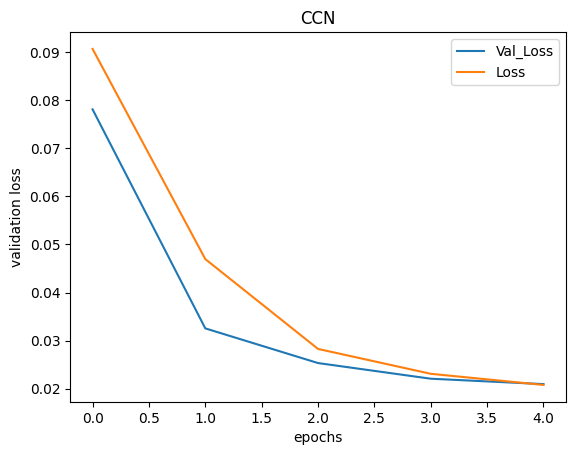

In [11]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('validation loss')
plt.title('CCN')
plt.legend(('Val_Loss', 'Loss'))
plt.show()

In [12]:
print(example_images.shape)
example_images = example_images.reshape((example_images.shape[0],
                                         example_images.shape[1],
                                         example_images.shape[2], 1))
print(example_images.shape)

(50, 28, 28)
(50, 28, 28, 1)


In [13]:
out = network.predict(example_images)

2/2 [==============================] - 0s 0s/step


In [14]:
out.shape

(50, 10)

<hr>

## extract intermediate layer

https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction

In [15]:
from tensorflow.keras.models import Model

layer_name = 'conv2d_1'
intermediate_layer_model = Model(inputs = network.input, 
            outputs = network.get_layer(layer_name).output)

intermediate_output = intermediate_layer_model.predict(example_images)

2/2 [==============================] - 0s 0s/step


In [16]:
print(intermediate_output.shape)

(50, 10, 10, 16)


In [17]:
# to compute RDM, will need to first reshape to 50xN array)
dim_of_rep = intermediate_output.shape[1] * intermediate_output.shape[2] * intermediate_output.shape[3]
print(dim_of_rep)
reshaped_intermediate_output = intermediate_output.reshape(intermediate_output.shape[0], dim_of_rep)

1600


In [18]:
# then calculate RDM like with pixel example

from scipy import stats

intermediate_RDM_Raw = np.zeros((Ndigits*Nexamples, Ndigits*Nexamples))
for i in range(50):
    for j in range(i, 50):
        a = reshaped_intermediate_output[i,:]
        b = reshaped_intermediate_output[j,:]
        r, p = stats.kendalltau(a, b)
        intermediate_RDM_Raw[i,j] = 1-r
        intermediate_RDM_Raw[j,i] = 1-r

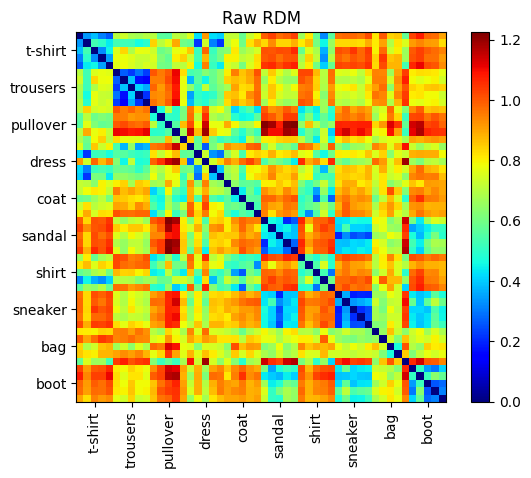

In [19]:
# display RDM
plt_rdm(intermediate_RDM_Raw)

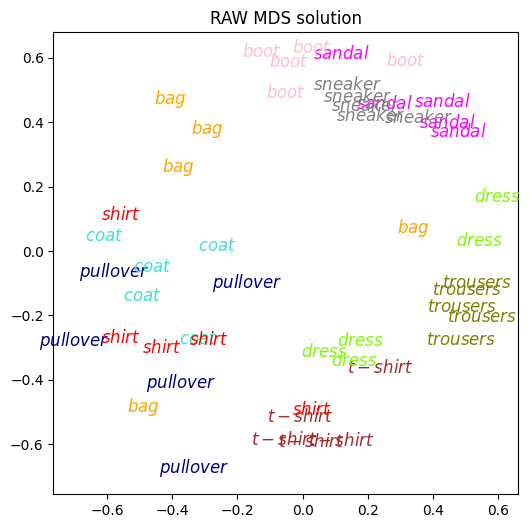

In [20]:
# perform MDS and display MDS
mds_sol(intermediate_RDM_Raw)

### Discussion

For this intermediate layer, representations clothing images of the same type mostly appear together
* Trousers, sneakers, and t-shirt all are `similar` to eachother
* Dress' and bags however are spread out (items of same category having `dissimilar` representations)

# 2c)
Look at representational similarity on final layer of network

In [22]:
# repeat for the penultimate layer of your CNN
from tensorflow.keras.models import Model

layer_name = 'dense_2'
final_layer_model = Model(inputs = network.input, 
            outputs = network.get_layer(layer_name).output)

final_output = final_layer_model.predict(example_images)

2/2 [==============================] - 0s 0s/step


In [26]:
from scipy import stats

final_RDM_Raw = np.zeros((Ndigits*Nexamples, Ndigits*Nexamples))
for i in range(50):
    for j in range(i, 50):
        a = final_output[i,:]
        b = final_output[j,:]
        r, p = stats.kendalltau(a, b)
        final_RDM_Raw[i,j] = 1-r
        final_RDM_Raw[j,i] = 1-r

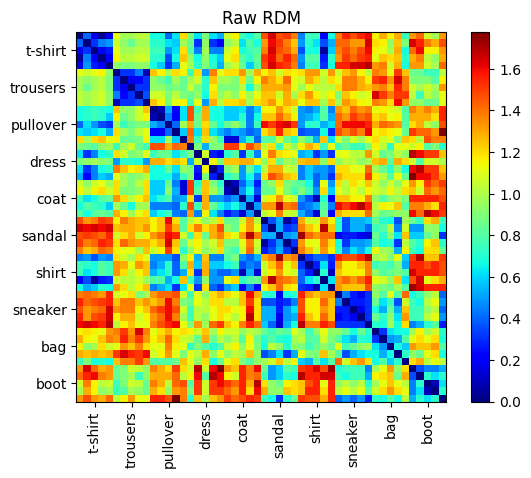

In [27]:
plt_rdm(final_RDM_Raw)


### Discussion

On this final output layer, representations of object of the same type are very similar, as seen by the blocks of squares in the main diagonal of the RDM. 
* At the final layer of CNN, objects of different categories have obtained distinct representaitons
  * A perfectly trained error-driven classifier would represent each category of the same type having dissimilarity of `0`, and object of differenty types having dissimilarity of `1` 

😀